<a href="https://colab.research.google.com/github/DianaShramchenko/works/blob/main/6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

### - **N.B.: Во всех заданиях, графический интерфейс для взаимодействия с обученной моделью, реализуется с помощью Gradio!**

### - **Для каждого задания в графическом интерфейсе должно быть встроено минимум 3 примера (sample)**

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета.

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [ ]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
import os
from keras.utils import image_dataset_from_directory
from imutils import paths
import pathlib
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
%%capture
DATADIR = 'Dataset'
if os.path.isdir(DATADIR)>0:
    print ('Data directory already exists and it is not empty, miss downloading')
else:
    print ('Data directory does not exists or it is empty, download the dataset')
    !gdown --id 1SaAEAxiqU4sSXsFEja1JRARpXCGQIkJN #Скопировать ID из ссылки в гугл диске
    !unzip Dataset.zip

In [ ]:
# инициализируем данные и метки
print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Собираем список путей к каждому изображению и перемешиваем их
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/content/imag_mini/")))
print(imagePaths[70].split(os.path.sep)[-2])
random.shuffle(imagePaths)

train


In [ ]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/content/imag_mini/")))
print(f"Количество найденных изображений: {len(imagePaths)}")

Количество найденных изображений: 80


In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/content/imag_mini/")

In [ ]:
print(data_dir)

/content/drive/MyDrive/content/imag_mini


In [ ]:
def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.

    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

In [ ]:
#В качестве кодировщика используем предобученную модель с архитектурой VGG16
from keras.applications.vgg16 import VGG16
vggmodel = VGG16() # Импортируем предобученную модель VGG16 с параметрами по умолчанию
newmodel = Sequential() # Создаём пустую модель

for i, layer in enumerate(vggmodel.layers): # Заполняем пустую модель слоями из предобученной модели VGG16
    if i<19:          # Только до 19-го слоя, чтобы включить только слои, используемые для извлечения признаков
      newmodel.add(layer)

newmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
for layer in newmodel.layers:
  layer.trainable=False   # Мы не хотим снова обучать эти слои, поэтому False.

In [ ]:
path = '/content/drive/MyDrive/content/imag_mini/'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=5, class_mode=None)

print(train)

Found 80 images belonging to 2 classes.


In [ ]:
print(train)
print(train[0].shape)

(5, 224, 224, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage.color import rgb2lab
import os

path = '/content/drive/MyDrive/content/imag_mini/'
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=5, class_mode=None)

print(train)
print(train[0].shape)

def process_batch(batch):
    X_batch = []
    Y_batch = []
    for img in batch:
        lab = rgb2lab(img)
        X_batch.append(lab[:,:,0])
        Y_batch.append(lab[:,:,1:] / 128)
    X_batch = np.array(X_batch)
    Y_batch = np.array(Y_batch)
    X_batch = X_batch.reshape(X_batch.shape + (1,))
    return X_batch, Y_batch

# Перемещение цикла for вне функции process_batch
for i in range(len(train)):
    batch = train.next()
    X, Y = process_batch(batch)
    # Здесь можно сохранить или использовать X и Y по мере необходимости
    print(f"Processed batch {i + 1}")

Found 80 images belonging to 2 classes.
(5, 224, 224, 3)
Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Processed batch 11
Processed batch 12
Processed batch 13
Processed batch 14
Processed batch 15
Processed batch 16


Original image (RGB) pixel [0,0]: [0.25882354 0.26666668 0.24705884]
Converted image (LAB) pixel [0,0]: [28.515312  -1.9314438  2.740103 ]


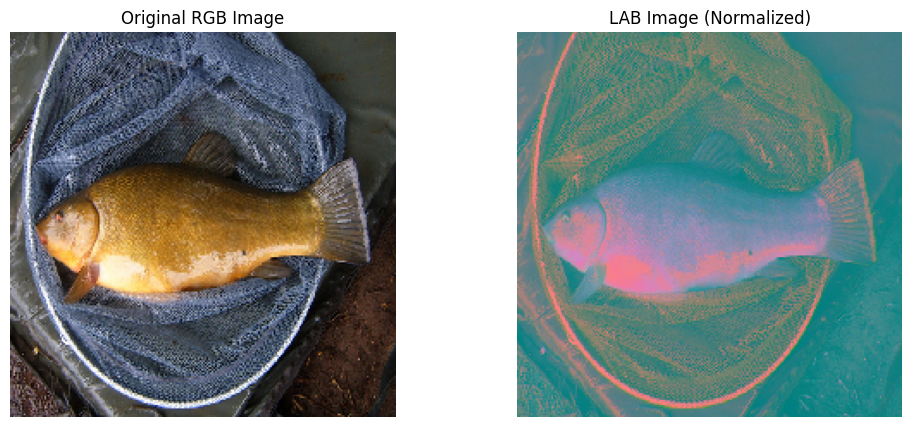

In [ ]:
#Проверка преобразования первого изображения в батче
original_img = batch[0]
lab_img = rgb2lab(original_img)

print("Original image (RGB) pixel [0,0]:", original_img[0, 0])
print("Converted image (LAB) pixel [0,0]:", lab_img[0, 0])

# Визуализация изображений
def show_images(rgb_img, lab_img):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(rgb_img)
    axes[0].set_title("Original RGB Image")
    axes[0].axis('off')

    lab_img_visual = (lab_img + [0, 128, 128]) / [100, 255, 255]  # Нормализация для визуализации
    axes[1].imshow(lab_img_visual)
    axes[1].set_title("LAB Image (Normalized)")
    axes[1].axis('off')

    plt.show()

show_images(original_img, lab_img)

In [ ]:
# Создается пустой список для хранения признаков, извлеченных с помощью VGG
vggfeatures = []

# Перебираются образцы в наборе данных X
for i, sample in enumerate(X):
  # Конвертируется одноканальное изображение в трехканальное (RGB)
  sample = gray2rgb(sample)
  # Изменяется форма образца для соответствия входу сети VGG16
  sample = sample.reshape((1,224,224,3))
  # Производится предварительная обработка образца для сети VGG16
  sample = keras.applications.vgg16.preprocess_input(sample)
  # Получается предсказание модели для обработанного образца
  prediction = newmodel.predict(sample)
  # Изменяется форма предсказания для соответствия выходу сети VGG16
  prediction = prediction.reshape((7,7,512))
  # Добавляется предсказание в список признаков
  vggfeatures.append(prediction)

# Преобразуется список признаков в NumPy массив
vggfeatures = np.array(vggfeatures)
# Выводится форма массива признаков
print(vggfeatures.shape)

1/1 [==============================] - 0s 17ms/step
(5, 7, 7, 512)


In [ ]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()


model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)       

In [ ]:
model.fit(vggfeatures, Y, verbose=1, epochs=1000, batch_size=256)

model.save('/content/colorize_autoencoder_VGG16.h5')

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.4090 - accuracy: 0.4161
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.6496 - accuracy: 0.5671
Epoch 3/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.8208 - accuracy: 0.6017
Epoch 4/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.7584 - accuracy: 0.5834
Epoch 5/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.7187 - accuracy: 0.5994
Epoch 6/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.5458 - accuracy: 0.5587
Epoch 7/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.5637 - accuracy: 0.4181
Epoch 8/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.5104 - accuracy: 0.4346
Epoch 9/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.4448 - accuracy: 0.4379
Epoch 10/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.2086 - accuracy: 0.5189
Epoch 11/10

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('/content/colorize_autoencoder_VGG16.h5',
                                   custom_objects=None,
                                   compile=True)

In [ ]:
#Тестирование обученной модели на пользовательских данных

# Задается путь к изображениям для обработки
testpath = '/content/drive/MyDrive/content/imag_mini/val/'

# Получается список файлов в указанной директории
files = os.listdir(testpath)

# Перебираются файлы в директории
for idx, file in enumerate(files):
    # Изображение преобразуется в массив и нормализуется
    test = img_to_array(load_img(os.path.join(testpath, file)))
    test = resize(test, (224, 224), anti_aliasing=True)
    test *= 1.0 / 255

    # Изображение конвертируется из RGB в Lab
    lab = rgb2lab(test)
    l = lab[:, :, 0]

    # Канал L преобразуется обратно в RGB
    L = gray2rgb(l)
    L = L.reshape((1, 224, 224, 3))

    # Изображение подготавливается для модели VGG16
    L = keras.applications.vgg16.preprocess_input(L)

    # Получается предсказание модели для канала L
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)

    # Каналы a и b умножаются на 128 для преобразования обратно в цветовое пространство LAB
    ab = ab * 128

    # Создается новое изображение с каналами L, a и b
    cur = np.zeros((224, 224, 3))
    cur[:, :, 0] = l
    cur[:, :, 1:] = ab

    # Преобразуем изображение в формат uint8 перед сохранением
    cur_rgb = lab2rgb(cur)
    cur_rgb_uint8 = (cur_rgb * 255).astype(np.uint8)

    # Изображение сохраняется на диск
    imsave('/content/' + str(idx) + ".jpg", cur_rgb_uint8)


1/1 [==============================] - 0s 17ms/step


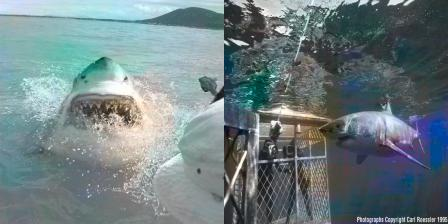

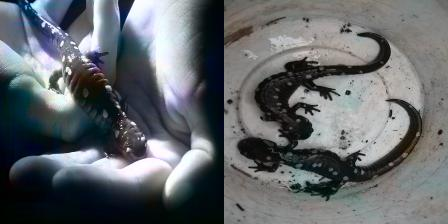

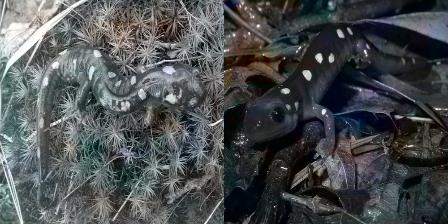

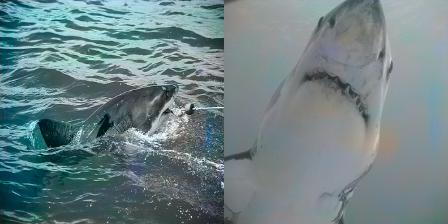

In [ ]:
#Вывод результатов:
from google.colab.patches import cv2_imshow
import numpy as np


imo_1 = cv2.imread("/content/0.jpg")
im_1 = cv2.imread("/content/1.jpg")
imo_2 = cv2.imread("/content/2.jpg")
im_2 = cv2.imread("/content/3.jpg")
imo_3 = cv2.imread("/content/4.jpg")
im_3 = cv2.imread("/content/5.jpg")
imo_4 = cv2.imread("/content/6.jpg")
im_4 = cv2.imread("/content/7.jpg")

pred_1 = np.concatenate((imo_1, im_1), axis=1)
pred_2 = np.concatenate((imo_2, im_2), axis=1)
pred_3 = np.concatenate((imo_3, im_3), axis=1)
pred_4 = np.concatenate((imo_4, im_4), axis=1)

cv2_imshow(pred_4)
cv2_imshow(pred_1)
cv2_imshow(pred_2)
cv2_imshow(pred_3)

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.datasets import cifar100

In [ ]:
%%capture
DATADIR = 'Dataset'
if os.path.isdir(DATADIR)>0:
    print ('Data directory already exists and it is not empty, miss downloading')
else:
    print ('Data directory does not exists or it is empty, download the dataset')
    !gdown --id 1SaAEAxiqU4sSXsFEja1JRARpXCGQIkJN #Скопировать ID из ссылки в гугл диске
    !unzip Dataset.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Собираем список путей к каждому изображению и перемешиваем их
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/content/forest/")))
print(imagePaths[10].split(os.path.sep)[-2])
random.shuffle(imagePaths)

forest


In [ ]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/content/forest/")))
print(f"Количество найденных изображений: {len(imagePaths)}")

Количество найденных изображений: 300


In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/content/forest/")

In [ ]:
def preprocess(images, shape):
  """
  Нормализует предоставленный массив и преобразует его в соответствующий формат.

  """

  proc_images = []
  for image in images:
      proc_image = cv2.imread(image)
      proc_image = cv2.resize(proc_image,  (shape[0], shape[1]))
      proc_images.append(proc_image)

  proc_images = np.array(proc_images).astype("float32") / 255.0
  return proc_images


def noise(array):
    """
    Добавляет случайный шум к каждому изображению в предоставленном массиве.

    """

    noise_factor = 0.1
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
# # инициализируем данные и метки
data = []

In [ ]:
# # Собираем список путей к каждому изображению и перемешиваем их
imagePaths = sorted(list(paths.list_images(data_dir)))
random.shuffle(imagePaths)

In [ ]:
img_h = 96 # Высота изображения в пикселях
img_w = 96 # Ширина изображения в пикселях
img_ch = 3 # Количество каналов в изображении

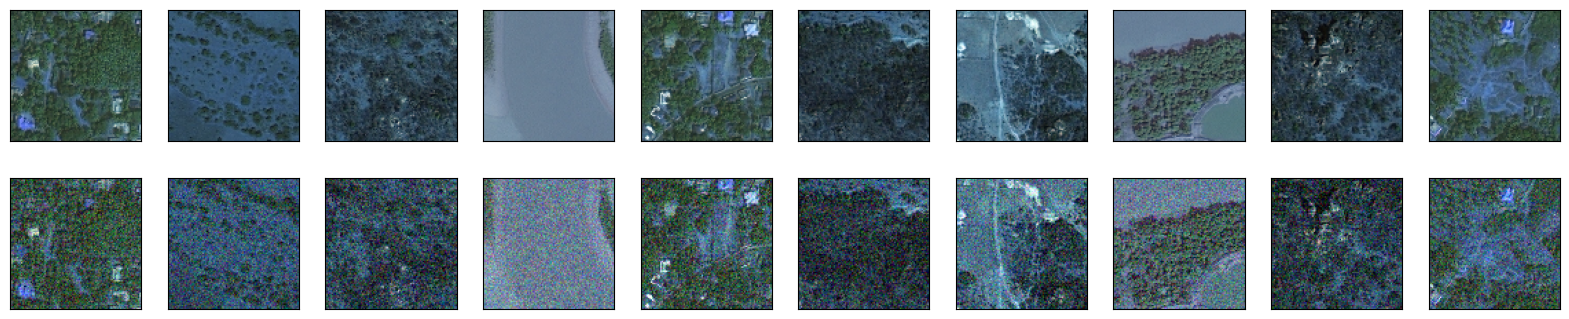

In [ ]:
# Нормализация и изменение формы данных
data = preprocess(imagePaths, (img_h,img_w,img_ch))
# Создание копии данных с добавленным шумом
noisy_data = noise(data)

# Отображение данных выборки и его версии с добавленным шумом
display(data, noisy_data)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Поскольку для кодирования и декодирования нам нужны только изображения из набора данных, мы
# не будем использовать метки классов

train_data, val_data, train_noisy_data, val_noisy_data = train_test_split(data, noisy_data, test_size=0.2, random_state=42)


print("Train Data Shape:", train_data.shape)
print("Validation Data Shape:", val_data.shape)
print("Train Noisy Data Shape:", train_noisy_data.shape)
print("Validation Noisy Data Shape:", val_noisy_data.shape)


Train Data Shape: (240, 96, 96, 3)
Validation Data Shape: (60, 96, 96, 3)
Train Noisy Data Shape: (240, 96, 96, 3)
Validation Noisy Data Shape: (60, 96, 96, 3)


In [ ]:
# Поскольку для кодирования и декодирования нам нужны только изображения из набора данных, мы
# не будем использовать метки классов
#train_data = load_images_from_directory(data_dir)
#test_data = load_images_from_directory(data_dir)
# Нормализация и изменение формы данных
#train_data = preprocess(train_data, (len(train_data), 28, 28, 1))
#test_data = preprocess(test_data, (len(train_data), 28, 28, 1))

# Создание копии данных с добавленным шумом
#noisy_train_data = noise(train_data)
#noisy_test_data = noise(test_data)

# Отображение данных выборки и его версии с добавленным шумом
#display(train_data, noisy_train_data)

TypeError: Can't convert object to 'str' for 'filename'

In [ ]:
input = layers.Input(shape=(96, 96, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 48, 48, 32)        9248

In [ ]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=15,
    shuffle=True,
    validation_data=(val_data, val_data),
)

Epoch 1/50
16/16 [==============================] - 7s 30ms/step - loss: 0.6772 - val_loss: 0.6455
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 0.6415 - val_loss: 0.6371
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6362 - val_loss: 0.6314
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.6291 - val_loss: 0.6251
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6213 - val_loss: 0.6181
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6154 - val_loss: 0.6142
Epoch 7/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6122 - val_loss: 0.6117
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 0.6098 - val_loss: 0.6094
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 0.6084 - val_loss: 0.6086
Epoch 10/50
16/16 [==============================] - 0s 12ms/step - loss: 0.6072 - val_loss: 0.6083
Epoch 11/

2/2 [==============================] - 1s 314ms/step


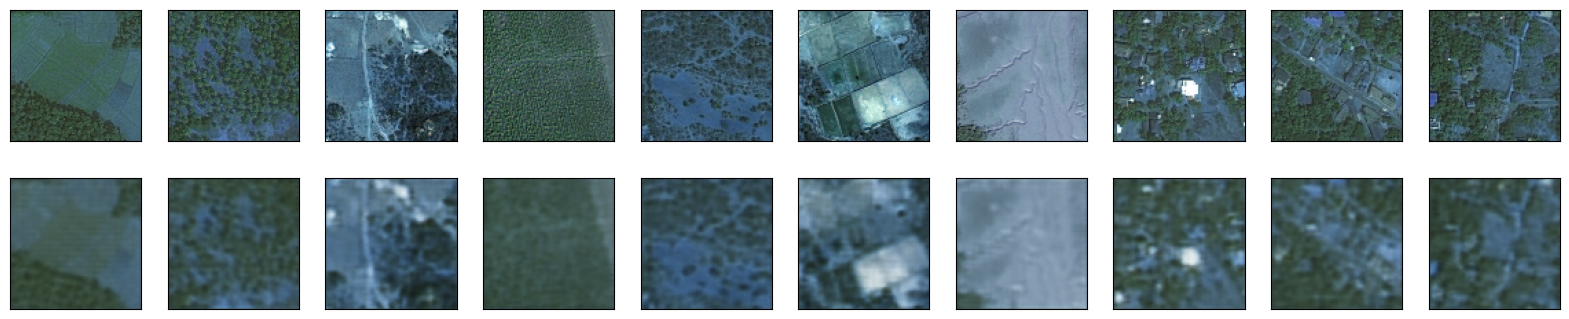

In [ ]:
predictions = autoencoder.predict(val_data)
display(val_data, predictions)

In [ ]:
#Использование автоэнкодера для удаления шума на изображении

In [ ]:
autoencoder.fit(
    x=train_noisy_data,
    y=train_data,
    epochs=50,
    batch_size=15,
    shuffle=True,
    validation_data=(val_noisy_data, val_data),
)

Epoch 1/50
16/16 [==============================] - 0s 20ms/step - loss: 0.6099 - val_loss: 0.6045
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 0.6036 - val_loss: 0.6042
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6028 - val_loss: 0.6040
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6025 - val_loss: 0.6036
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6023 - val_loss: 0.6036
Epoch 6/50
16/16 [==============================] - 0s 12ms/step - loss: 0.6022 - val_loss: 0.6035
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 0.6021 - val_loss: 0.6035
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6021 - val_loss: 0.6035
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6021 - val_loss: 0.6034
Epoch 10/50
16/16 [==============================] - 0s 15ms/step - loss: 0.6021 - val_loss: 0.6034
Epoch 11/

2/2 [==============================] - 0s 10ms/step


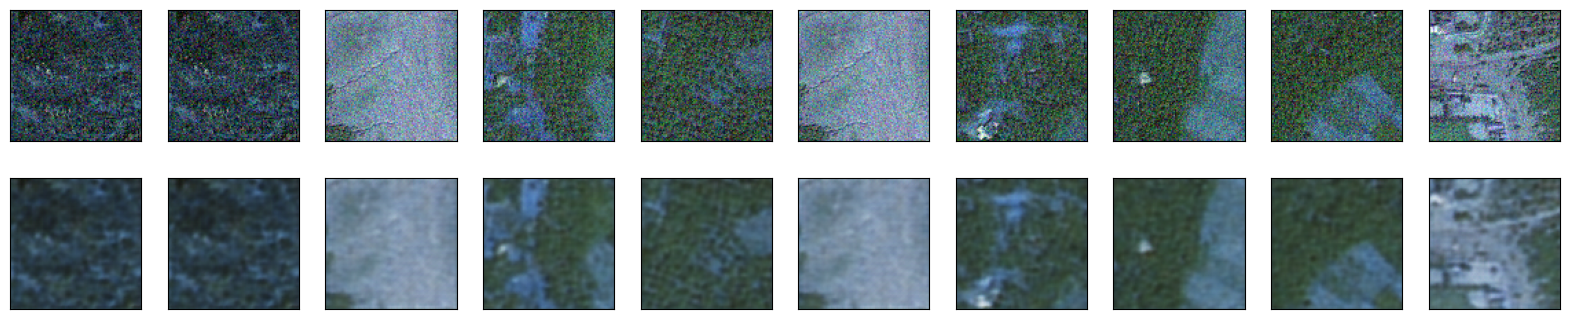

In [ ]:
predictions = autoencoder.predict(val_noisy_data)
display(val_noisy_data, predictions)

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку.

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [ ]:
# Импортируем LabelBinarizer для преобразования текстовых меток в векторы
# (например, "кошка" -> [1, 0, 0], "собака" -> [0, 1, 0], "панда" -> [0, 0, 1])
from sklearn.preprocessing import LabelBinarizer

# Импортируем train_test_split для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

# Импортируем classification_report для оценки качества классификации
from sklearn.metrics import classification_report

# Импортируем Sequential для создания последовательной модели нейронной сети
from keras.models import Sequential

# Импортируем Dense для создания плотных слоев нейронной сети
from keras.layers import Dense, Conv2D, Flatten

# Импортируем SGD и Adam для оптимизации обучения нейронной сети
from keras.optimizers import SGD, Adam

# Импортируем paths из imutils для удобной работы с путями к изображениям
from imutils import paths

# Импортируем pyplot из matplotlib для визуализации данных
import matplotlib.pyplot as plt

# Импортируем numpy для работы с массивами данных
import numpy as np

# Импортируем random для генерации случайных чисел
import random

# Импортируем pickle для сериализации и десериализации данных
import pickle

# Импортируем cv2 для работы с изображениями
import cv2

# Импортируем os для работы с файловой системой
import os

# Импортируем cv2_imshow из google.colab.patches для отображения изображений в Colab
from google.colab.patches import cv2_imshow

from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image
from urllib.request import urlopen
from imutils import paths
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Собираем список путей к каждому изображению и перемешиваем их
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/content/anim/")))
print(imagePaths[10].split(os.path.sep)[-2])
random.shuffle(imagePaths)

cats


In [ ]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/content/anim/")))
print(f"Количество найденных изображений: {len(imagePaths)}")

Количество найденных изображений: 60


In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/content/anim/")

In [ ]:
def load_images(imagePaths, compression_size = 256):
  data = []
  half_length = len(imagePaths) // 4
  for imagePath in imagePaths[:half_length]:
    # Загрузка изображения
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (compression_size, compression_size))

    # Добавление изображения в список
    data.append(image)

  return data

data = load_images(imagePaths, 256)
data = np.array(data, dtype="float") / 255.0

In [ ]:
def load_orig(imagePaths, compression_size = 512):
  data = []
  half_length = len(imagePaths) // 4
  for imagePath in imagePaths[:half_length]:
    # Загрузка изображения
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (compression_size, compression_size))
    # Добавление изображения в список
    data.append(image)

  return data
orig = load_orig(imagePaths, 512)
orig = np.array(orig, dtype="float") / 255.0

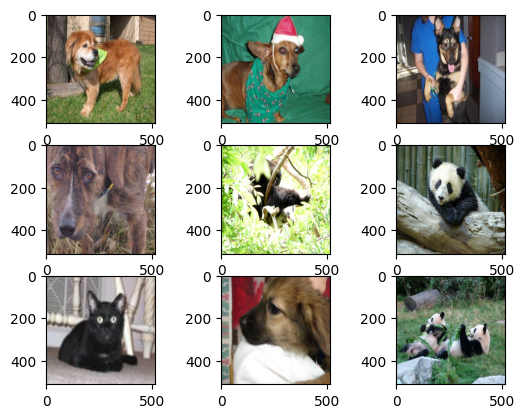

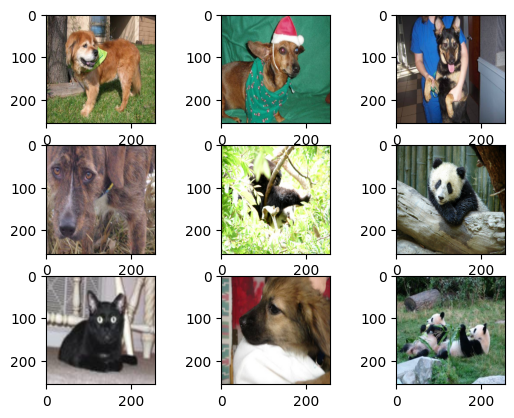

In [ ]:
import matplotlib.pyplot as plt

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(orig[i], cmap=plt.get_cmap('gray'))

plt.show()

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(data[i], cmap=plt.get_cmap('gray'))

plt.show()

In [ ]:
(trainX, valX) = train_test_split(data, test_size=0.25, random_state=28)
(origTrainX, origValX) = train_test_split(orig, test_size=0.25, random_state=28)
print(trainX)
print(valX)
print(origTrainX)
print(origValX)

[[[[0.61960784 0.58823529 0.57647059]
   [0.62352941 0.6        0.58431373]
   [0.64313725 0.62352941 0.60392157]
   ...
   [0.45098039 0.17254902 0.18823529]
   [0.43137255 0.20784314 0.22352941]
   [0.42745098 0.21176471 0.22352941]]

  [[0.63921569 0.6        0.58823529]
   [0.64313725 0.60392157 0.59607843]
   [0.65882353 0.62352941 0.61176471]
   ...
   [0.49803922 0.23137255 0.24705882]
   [0.43137255 0.22352941 0.23529412]
   [0.39607843 0.19607843 0.20784314]]

  [[0.64313725 0.58823529 0.58431373]
   [0.65098039 0.59607843 0.59215686]
   [0.6627451  0.61960784 0.61176471]
   ...
   [0.49411765 0.25882353 0.2627451 ]
   [0.41568627 0.22745098 0.23529412]
   [0.34901961 0.16470588 0.17647059]]

  ...

  [[0.52941176 0.50980392 0.49803922]
   [0.55294118 0.53333333 0.52156863]
   [0.57647059 0.55686275 0.54509804]
   ...
   [0.49803922 0.35686275 0.20784314]
   [0.49019608 0.35294118 0.20392157]
   [0.49411765 0.36078431 0.21176471]]

  [[0.5254902  0.50196078 0.49411765]
   [0.5

In [ ]:
# Encoder
from keras.layers import Input, Conv2D, UpSampling2D
from keras.optimizers import Adam
from keras import layers
from keras.models import Model


# Гиперпараметры
input_shape = (256, 256, 3)
output_shape = (512, 512, 3)
batch_size = 15
epochs = 50

# Создание модели автоэнкодера
input_img = Input(shape=input_shape)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D()(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder3 = Model(input_img, decoded)
autoencoder3.compile(optimizer='adam', loss='mse')

In [ ]:
#обучаем модель
H = autoencoder3.fit(trainX,
                origTrainX,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(valX, origValX))

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.0723 - val_loss: 0.0766
Epoch 2/50
1/1 [==============================] - 0s 198ms/step - loss: 0.0675 - val_loss: 0.0749
Epoch 3/50
1/1 [==============================] - 0s 189ms/step - loss: 0.0644 - val_loss: 0.0744
Epoch 4/50
1/1 [==============================] - 0s 190ms/step - loss: 0.0626 - val_loss: 0.0746
Epoch 5/50
1/1 [==============================] - 0s 206ms/step - loss: 0.0616 - val_loss: 0.0747
Epoch 6/50
1/1 [==============================] - 0s 191ms/step - loss: 0.0609 - val_loss: 0.0741
Epoch 7/50
1/1 [==============================] - 0s 195ms/step - loss: 0.0601 - val_loss: 0.0727
Epoch 8/50
1/1 [==============================] - 0s 200ms/step - loss: 0.0590 - val_loss: 0.0708
Epoch 9/50
1/1 [==============================] - 0s 197ms/step - loss: 0.0577 - val_loss: 0.0688
Epoch 10/50
1/1 [==============================] - 0s 195ms/step - loss: 0.0563 - val_loss: 0.0671
Epoch 11/50
1/1 [=====

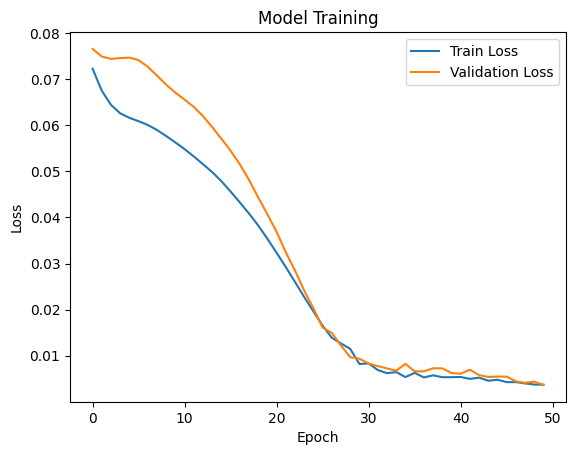

In [ ]:
# строим график обучения
plt.plot(H.history['loss'], label='Train Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.title('Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

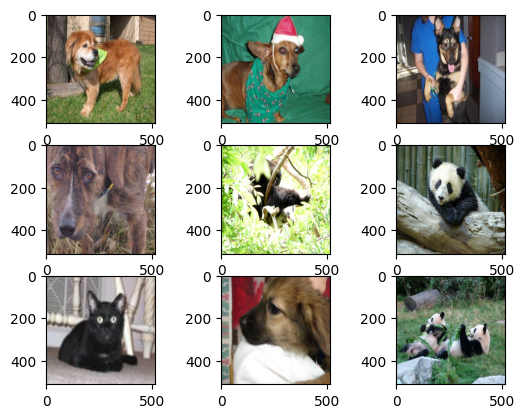

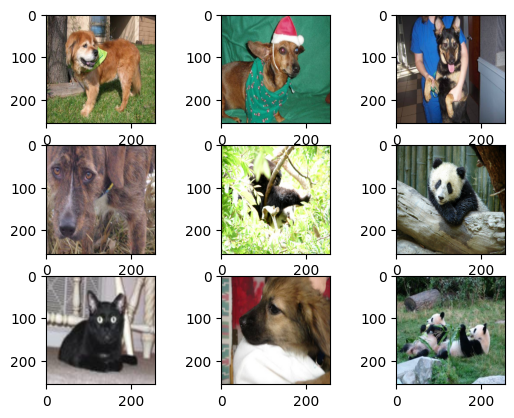

1/1 [==============================] - 3s 3s/step


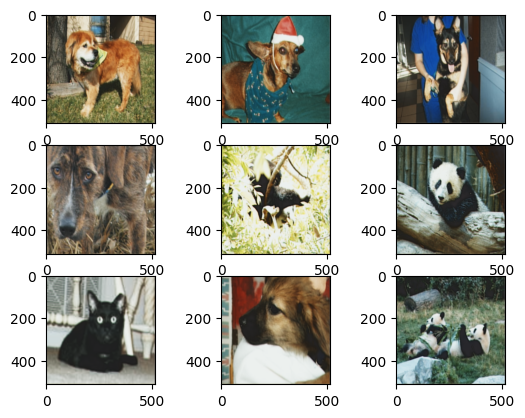

In [ ]:
import matplotlib.pyplot as plt

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(orig[i], cmap=plt.get_cmap('gray'))

plt.show()

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(data[i], cmap=plt.get_cmap('gray'))

plt.show()

predictions = autoencoder3.predict(data)

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(predictions[i], cmap=plt.get_cmap('gray'))

plt.show()